# 1. Import Ntuple

In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util

training_variables = util.training_variables
columns = util.all_relevant_variables

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


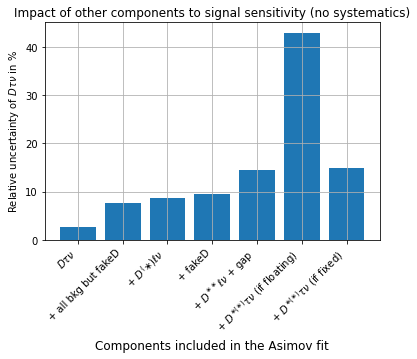

In [14]:
# Sample Data
x_categories = [r'$D\tau\nu$', '+ all bkg but fakeD', r'+ $D^(\ast)\ell\nu$', '+ fakeD',
                r'+ $D^{\ast\ast}\ell\nu$ + gap', r'+ $D^{\ast(\ast)}\tau\nu$ (if floating)',
                r'+ $D^{\ast(\ast)}\tau\nu$ (if fixed)']
y_values = [2.74, 7.64, 8.66, 9.58, 14.5, 43, 15]

# Create the bar plot
# plt.figure(figsize=(10, 6))  # Adjust width and height as needed
plt.bar(x_categories, y_values)

# Add labels and title (optional)
plt.xlabel('Components included in the Asimov fit', fontsize=12)
plt.ylabel(r'Relative uncertainty of $D\tau\nu$ in %')
plt.title('Impact of other components to signal sensitivity (no systematics)')

# Display the plot
plt.xticks(rotation=45, ha='right') # Rotate labels 45 degrees, adjust horizontal alignment
plt.grid()
plt.show()


In [4]:
# 4S Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1) & (B0_dr<0.1)'

# (DstVeto_massDiff_0<0.135 or 0.145<DstVeto_massDiff_0) and 1.855<D_M<1.885

# Load data files
MC_4S = uproot.concatenate(['../../Samples/MC15ri/e_channel/local_200fb_test/*.root:B0'], # 1ab_quaxo_3
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

# MC_sig = uproot.concatenate(['../../Samples/MC15ri/e_channel/sig_quaxo_e_1/*.root:B0'],
#                           library="np",
#                           cut = cut,
#                           filter_branch=lambda branch: branch.name in columns)

df_mc_4S = pd.DataFrame(MC_4S).sample(frac=1).reset_index(drop=True)
# df_mc_sig = pd.DataFrame(MC_sig)

In [5]:
lgb_tight = 'sig_prob>0.65 and fakeD_prob<0.05'
lgb_loose = 'sig_prob>0.5 and fakeD_prob<0.1 and continuum_prob<0.5 and combinatorial_prob<0.5'

for df in [df_mc_4S]:
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_mc_4S_lgb = util.apply_mva_bcs(df_mc_4S, training_variables, lgb_loose, library='lgbm')
# df_mc_sig_lgb = util.apply_mva_bcs(df_mc_sig, training_variables, lgb_tight, library='lgbm')

In [ ]:
samples_generic = util.classify_mc_dict(df_mc_4S_lgb, 'e', template=False)
samples_sig = util.classify_mc_dict(df_mc_sig_lgb, 'e', template=False)
mpl=util.mpl(samples_generic)
for name, df in samples_generic.items():
    print(name, len(df))

In [6]:
# D mass signal region
samples_generic = util.classify_mc_dict(df_mc_4S_lgb.query('1.855<D_M<1.885'), 'e', template=False)
# samples_sig = util.classify_mc_dict(df_mc_sig_lgb.query('1.855<D_M<1.885'), 'e', template=False)
mpl=util.mpl(samples_generic)
# mpl_sig = util.mpl(samples_sig)
for name, df in samples_generic.items():
    print(name, len(df))

bkg_fakeD 9964
bkg_TDFl 135
bkg_fakeTracks 718
bkg_continuum 5476
bkg_combinatorial 6972
bkg_singleBbkg 3409
bkg_other_TDTl 0
$D\tau\nu$ 1361
$D^\ast\tau\nu$ 778
$D\ell\nu$ 29670
$D^\ast\ell\nu$ 20208
$D^{\ast\ast}\tau\nu$ 537
$D^{\ast\ast}\ell\nu$_narrow 6490
$D^{\ast\ast}\ell\nu$_broad 4738
$D\ell\nu$_gap_pi 1319
$D\ell\nu$_gap_eta 1060
bkg_other_signal 0


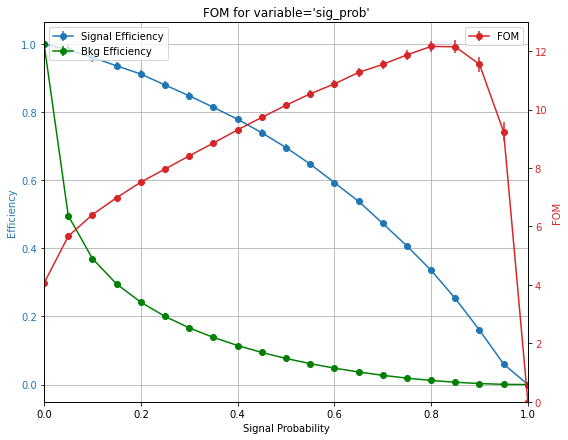

In [19]:
# lgbm
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_fakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='sig_prob', test_points=tests)

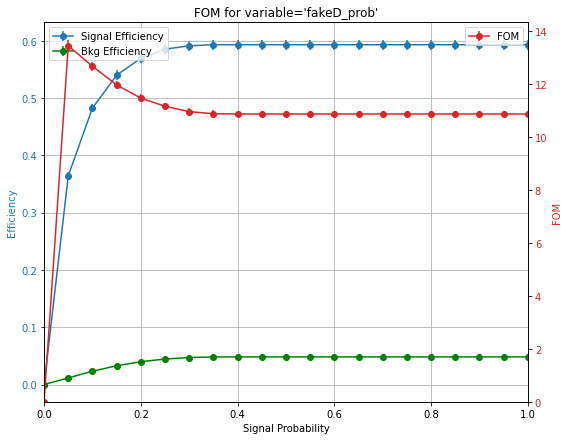

In [20]:
# lightgbm
tests = np.linspace(0,1,21)
mpl.plot_FOM(sigModes=[r'$D\tau\nu$'],bkgModes=['bkg_fakeD','bkg_TDFl','bkg_fakeTracks',
                                                'bkg_continuum','bkg_combinatorial','bkg_singleBbkg'],
            variable='fakeD_prob', test_points=tests, cut='sig_prob>0.6',reverse=True)

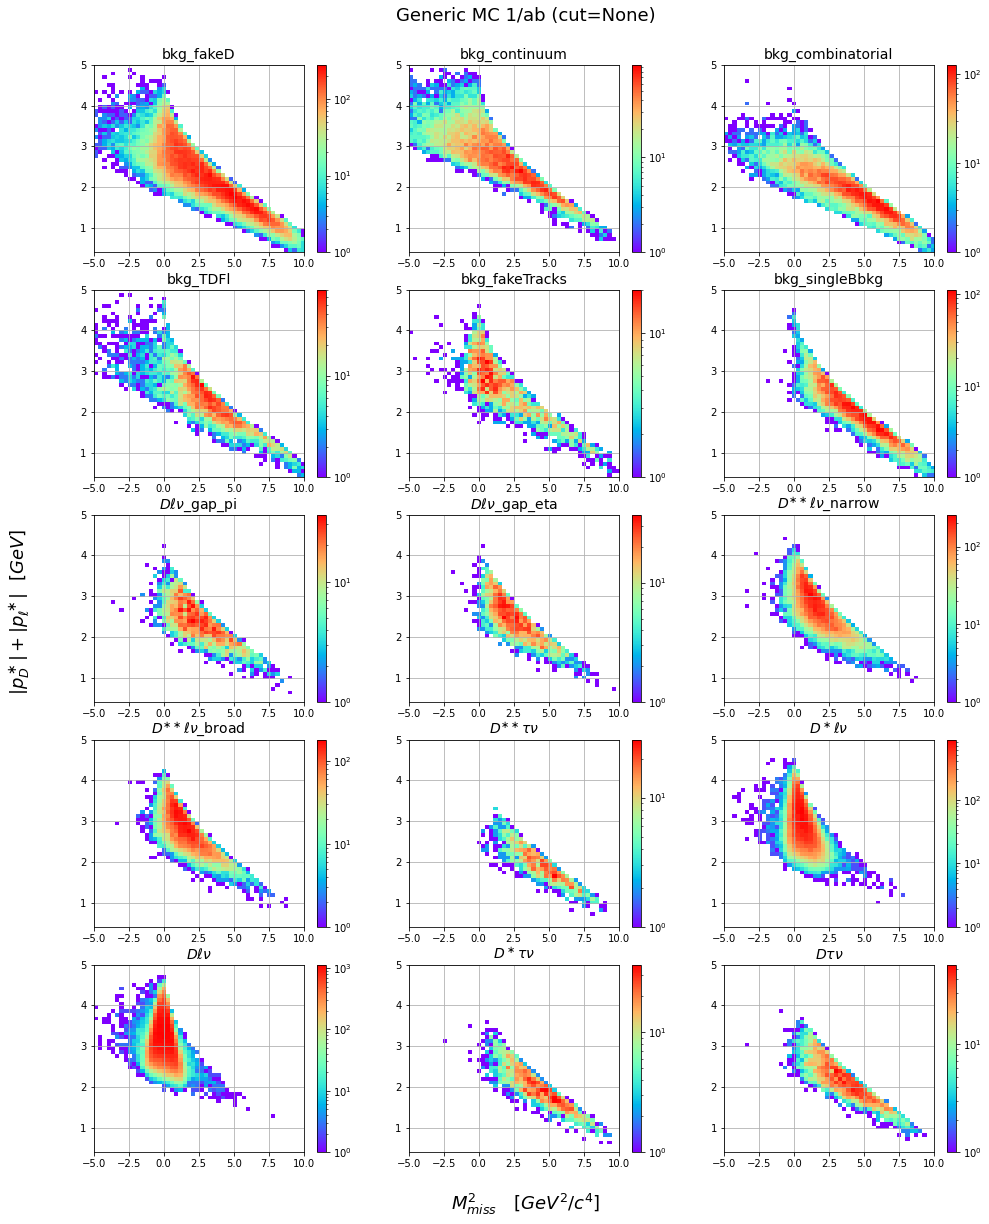

In [9]:
# Define the fitting range and number of bins, 'p_D_l'
start = 0.4
end = 5
num_bins = 50

# Create the bin edges
p_D_l_bins = np.linspace(start, end, num_bins + 1)

# Define the fitting range and number of bins, 'B0_CMS3_weMissM2'
start = -5
end = 10
num_bins = 50

# Create the bin edges
MM2_bins = np.linspace(start, end, num_bins + 1)

mpl.plot_all_2Dhist(bin_list=[MM2_bins,p_D_l_bins], mask=None,title='Generic MC 1/ab')

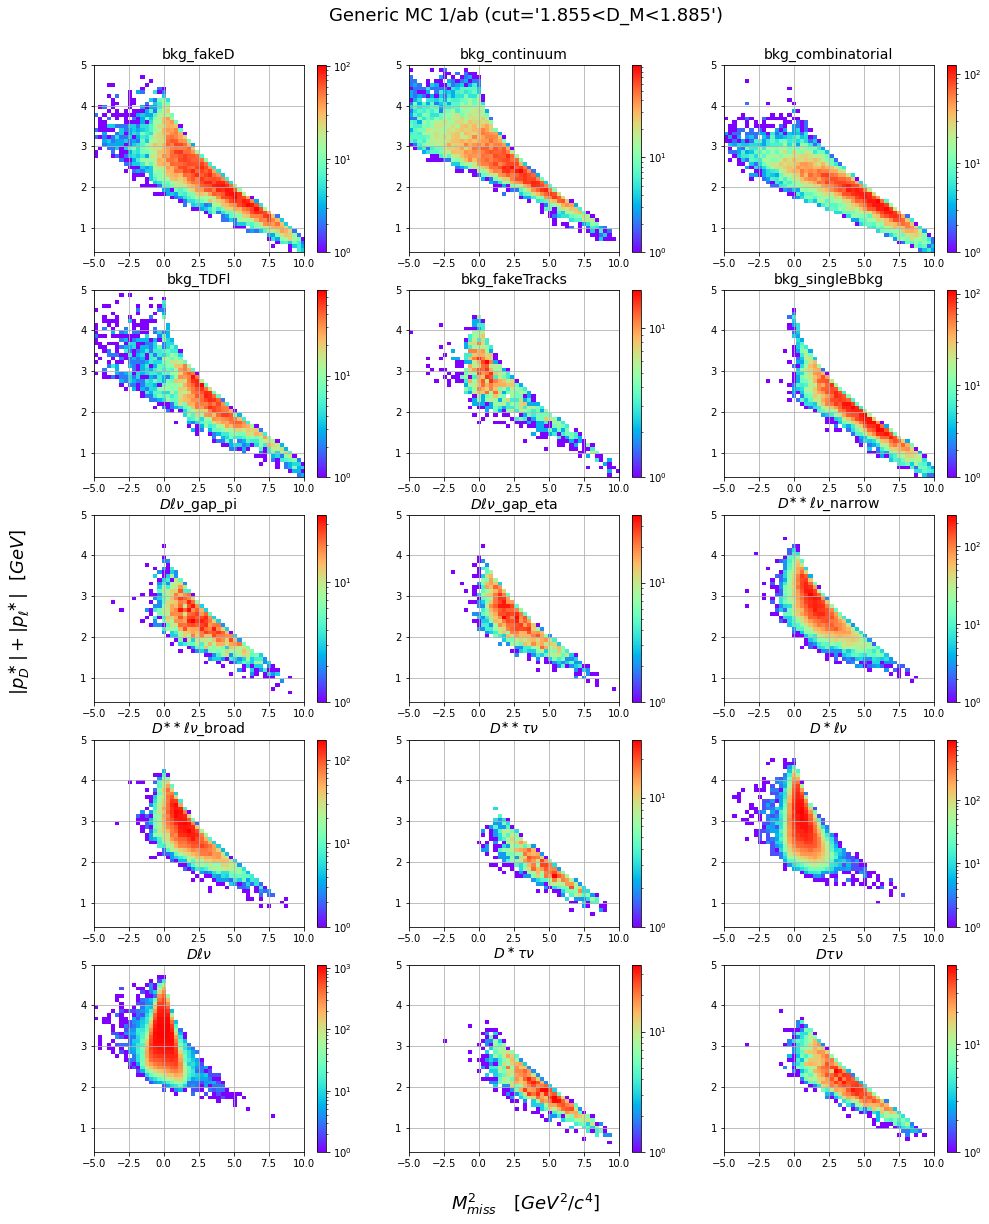

In [8]:
mpl.plot_all_2Dhist(bin_list=[MM2_bins,p_D_l_bins],cut='1.855<D_M<1.885',title='Generic MC 1/ab',mask=None)

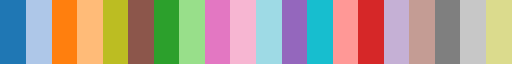

In [10]:
util.my_cmap

# SIG distribution at M_D signal region

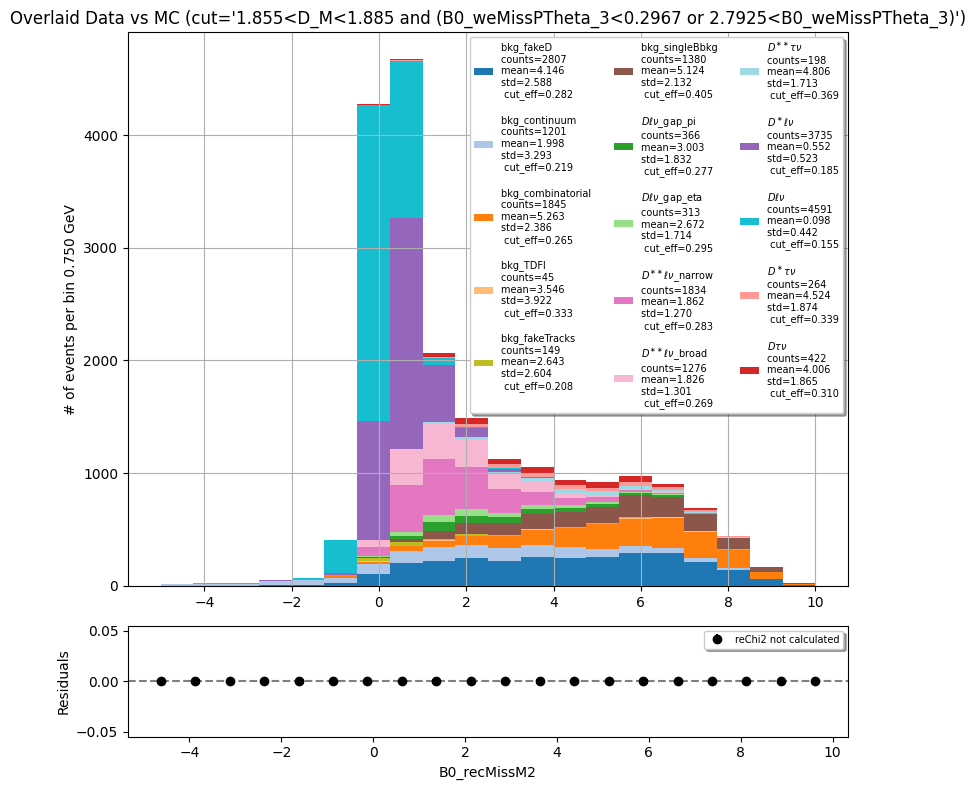

In [28]:
b1 = np.linspace(-5,10,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_recMissM2',bins=b1,cut='1.855<D_M<1.885 and (B0_weMissPTheta_3<0.2967 or 2.7925<B0_weMissPTheta_3)',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

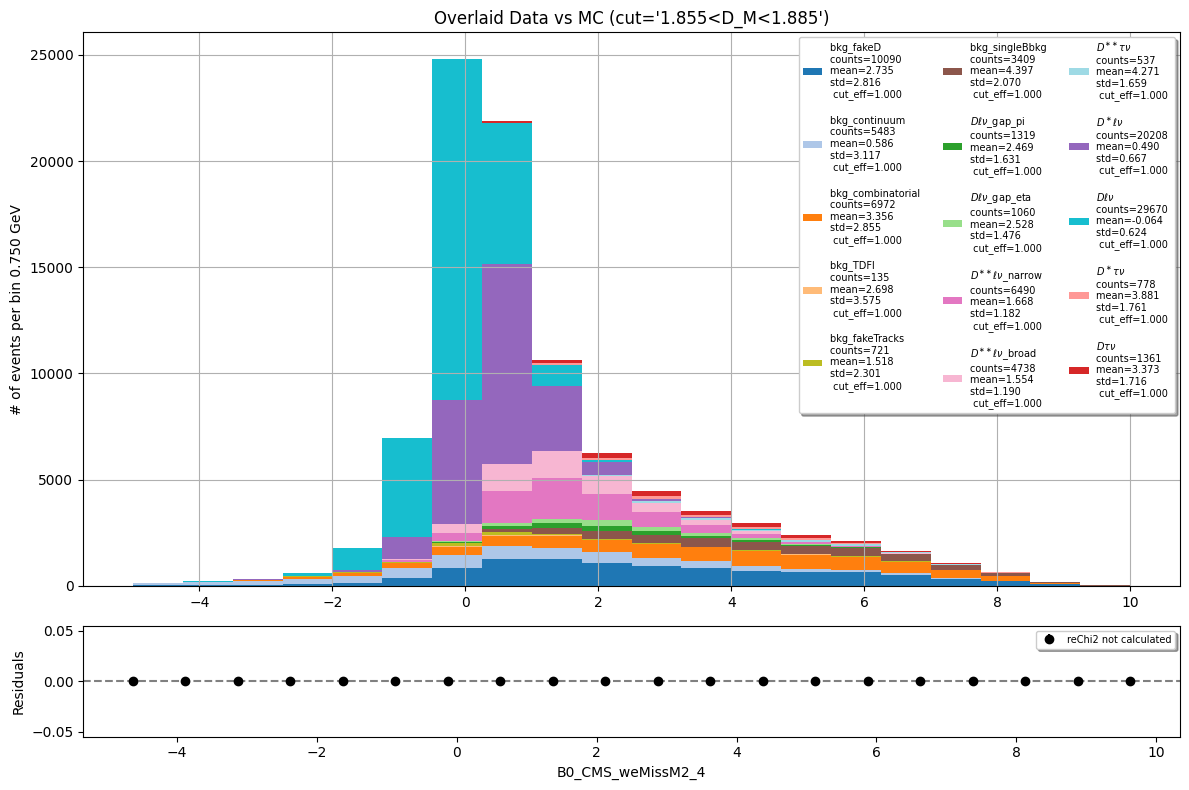

In [31]:
b1 = np.linspace(-5,10,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS_weMissM2_4',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

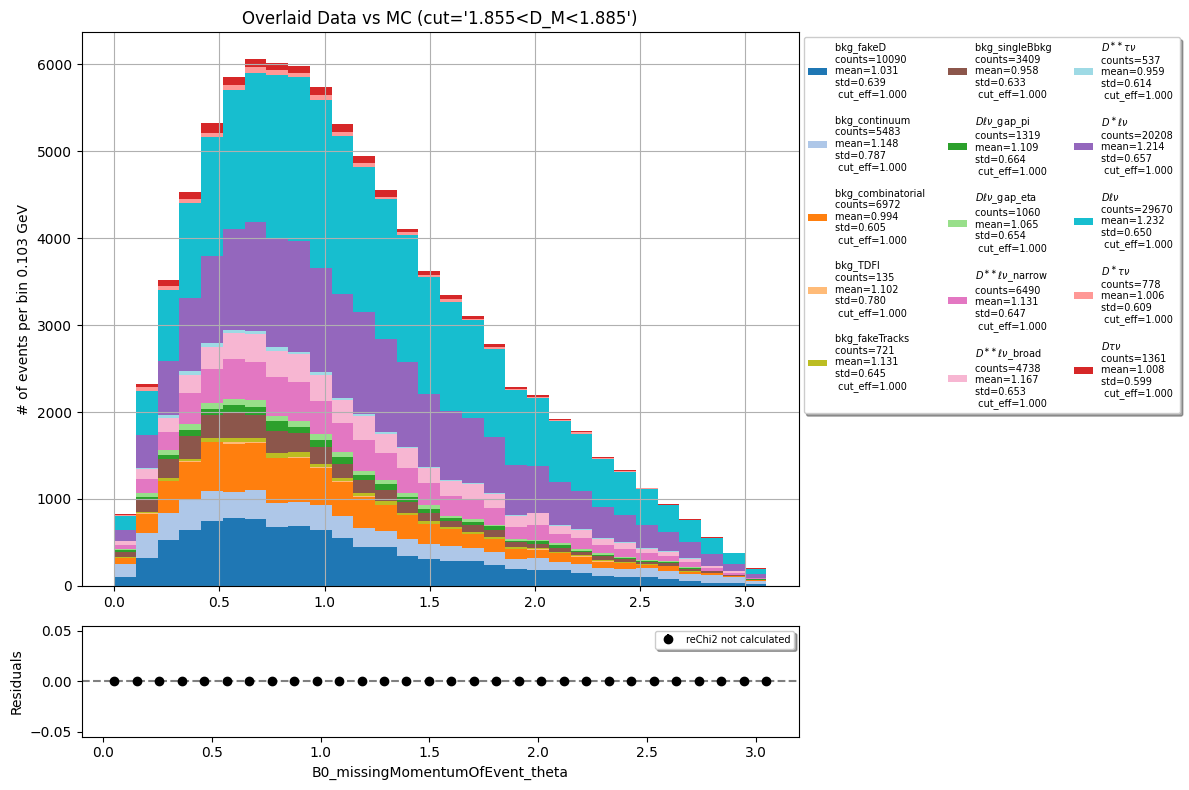

In [99]:
b1 = np.linspace(0,3.1,31)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_missingMomentumOfEvent_theta',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

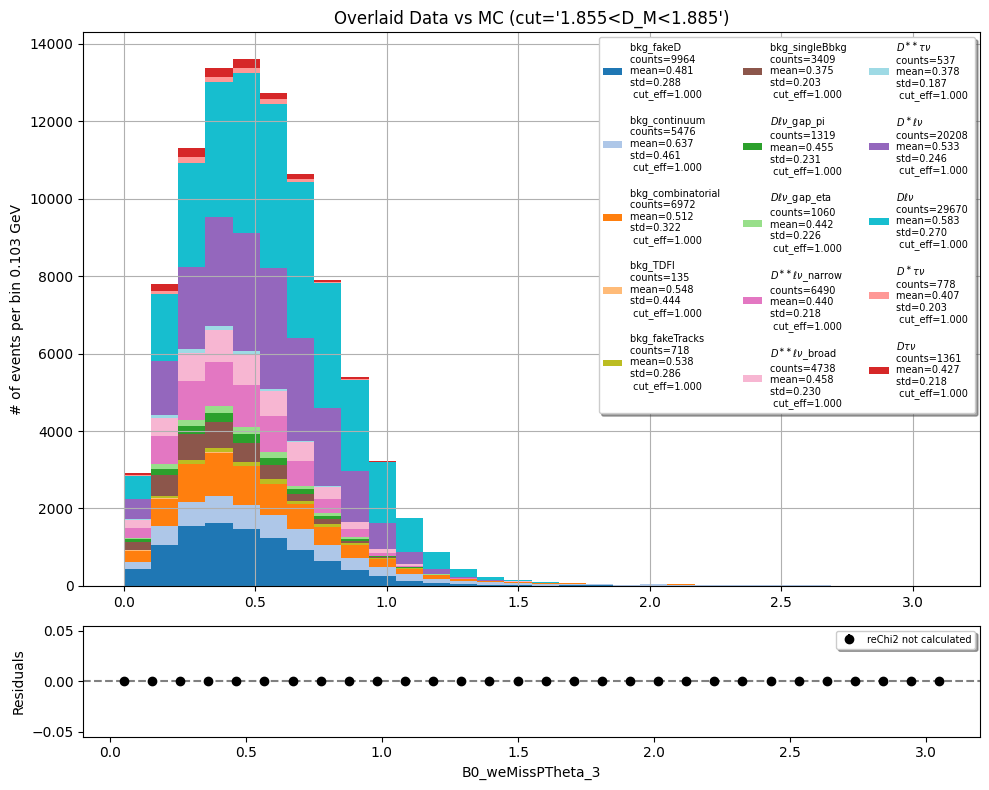

In [27]:
b1 = np.linspace(0,3.1,31)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_weMissPTheta_3',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(10,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

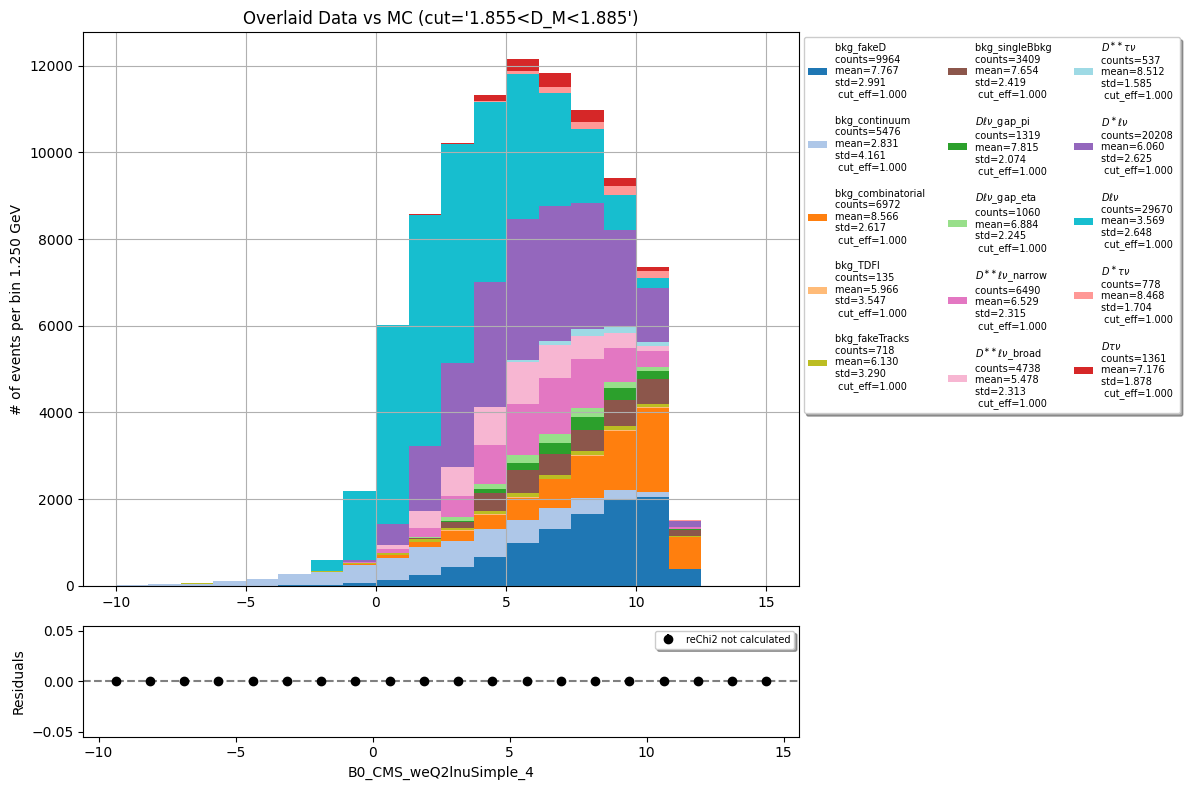

In [21]:
b1 = np.linspace(-10,15,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS_weQ2lnuSimple_4',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

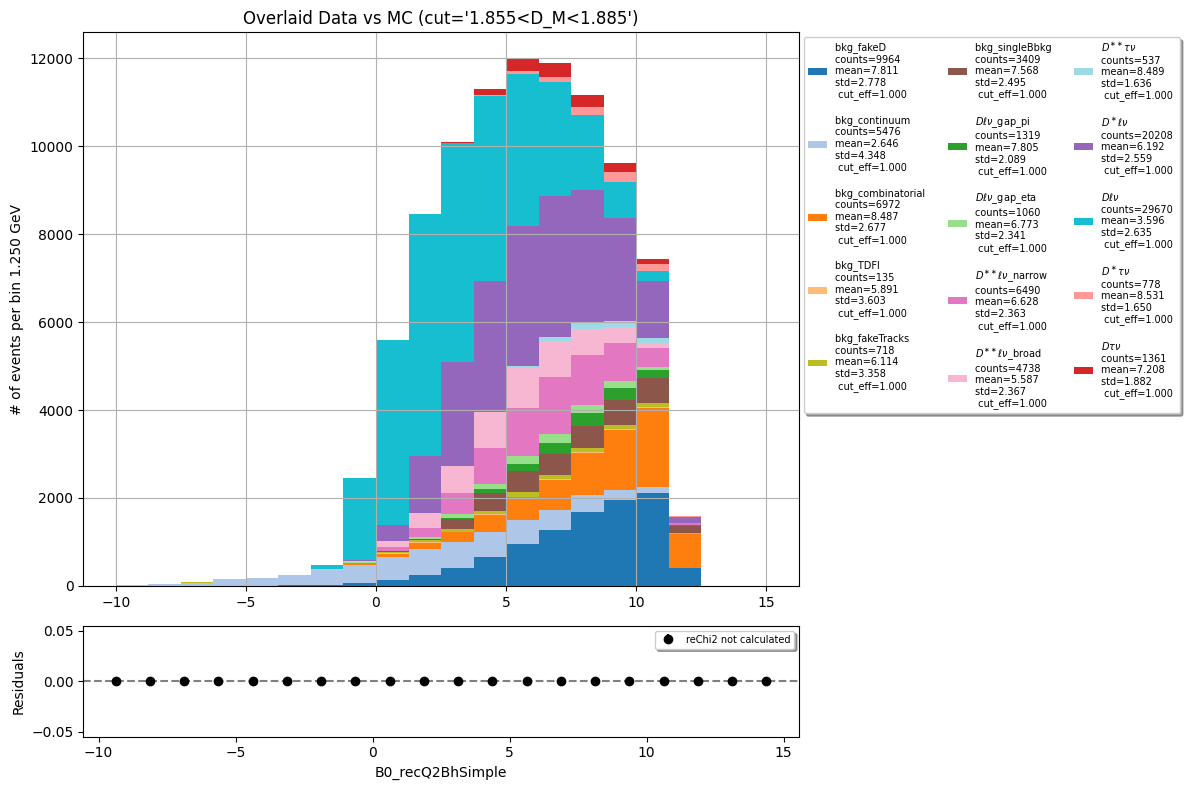

In [19]:
b1 = np.linspace(-10,15,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_recQ2BhSimple',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

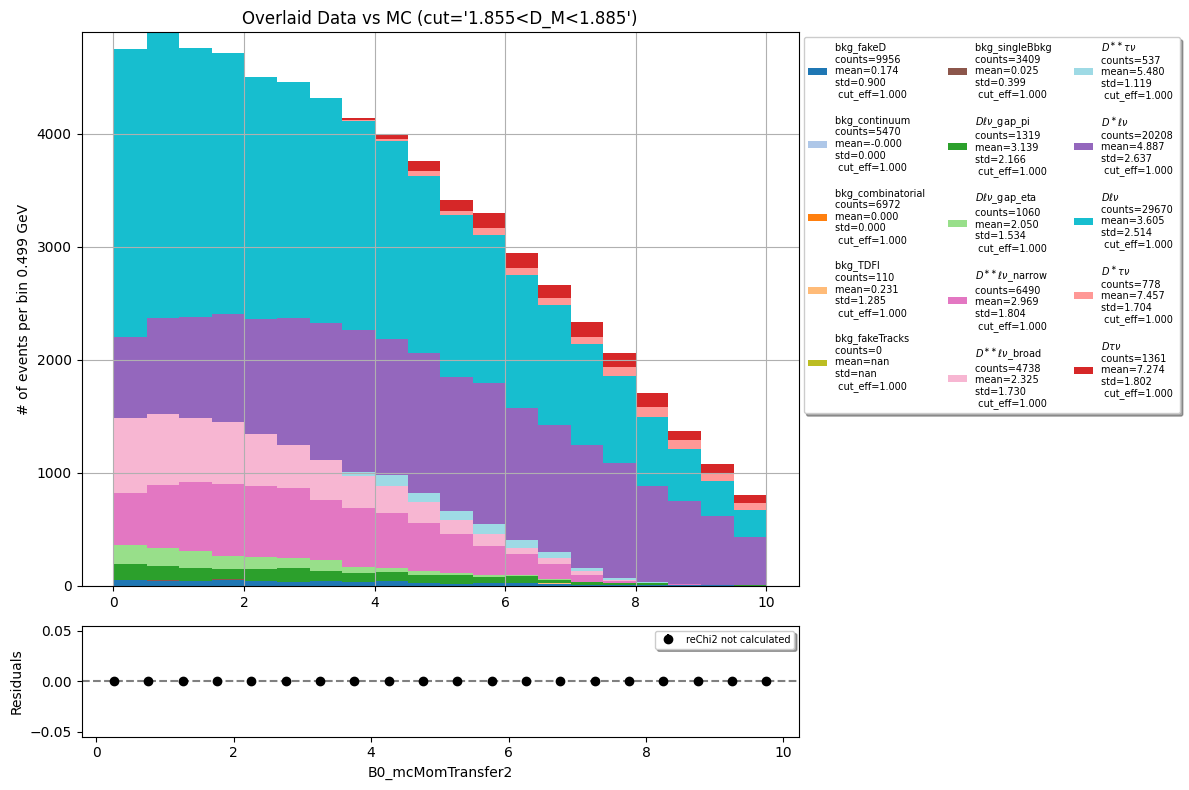

In [18]:
b1 = np.linspace(0.01,10,21)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_mcMomTransfer2',bins=b1,cut='1.855<D_M<1.885',density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

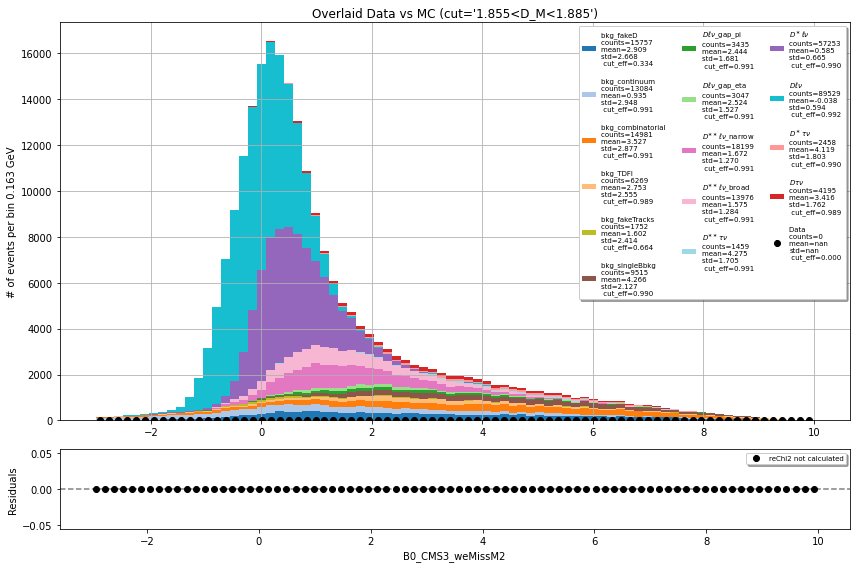

In [7]:
b1 = np.linspace(-3,10,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weMissM2',bins=b1,cut='1.855<D_M<1.885',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

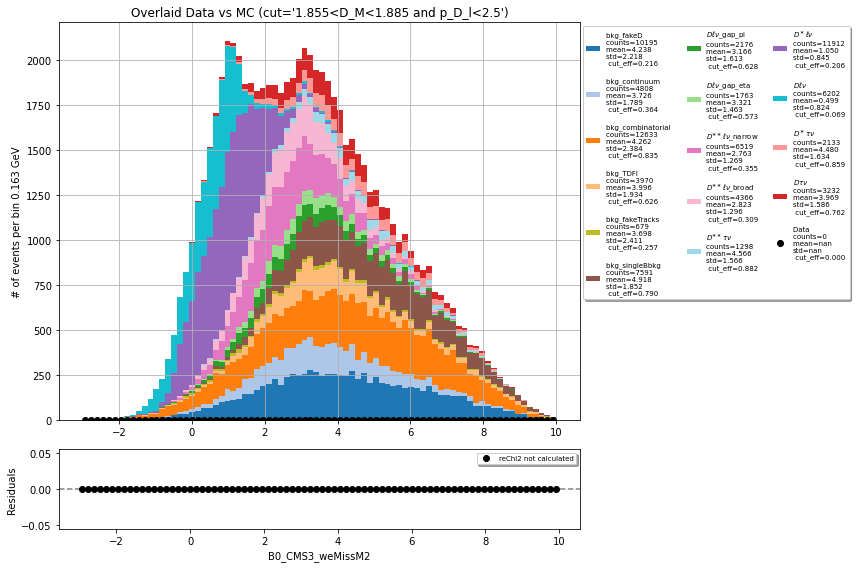

In [13]:
b1 = np.linspace(-3,10,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='B0_CMS3_weMissM2',bins=b1,cut='1.855<D_M<1.885 and p_D_l<2.5',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

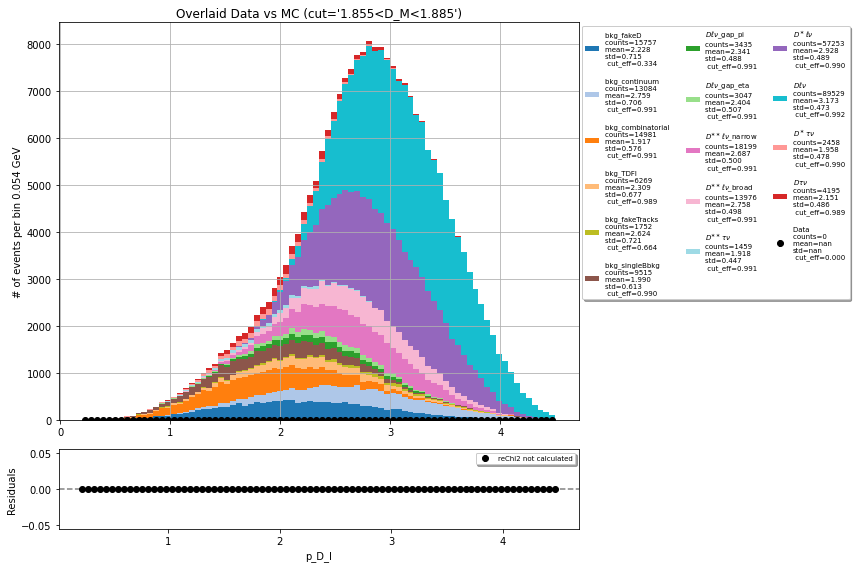

In [14]:
b1 = np.linspace(0.2,4.5,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='p_D_l',bins=b1,cut='1.855<D_M<1.885',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

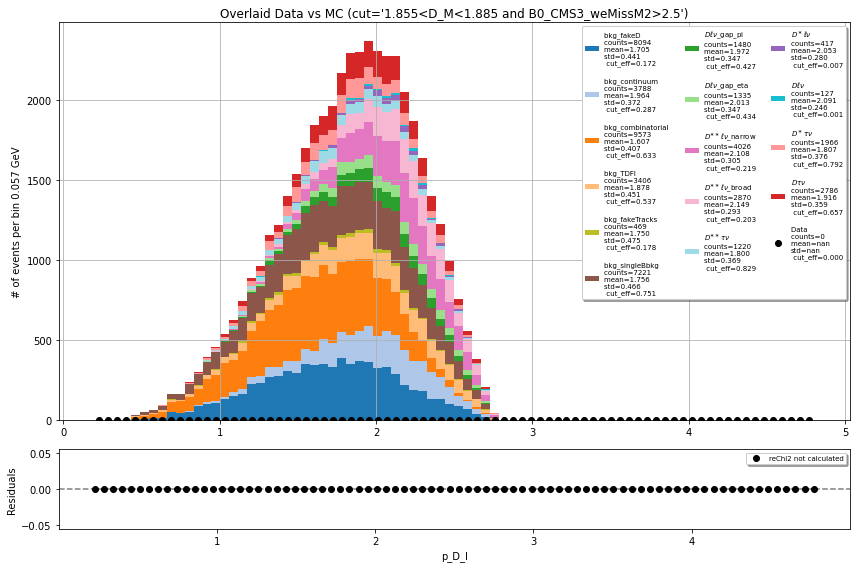

In [15]:
b1 = np.linspace(0.2,4.8,81)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='p_D_l',bins=b1,cut='1.855<D_M<1.885 and B0_CMS3_weMissM2>2.5',scale=[1,187/200],density=False,
    correction=False,mask=[],figsize=(12,8),ratio=False,data_sig_mask=True,
                                legend_nc=3, legend_fs=7)

Text(0.5, 0, '$M_{\\gamma\\rightarrow e^+ e^-}$  [Gev/c^2]')

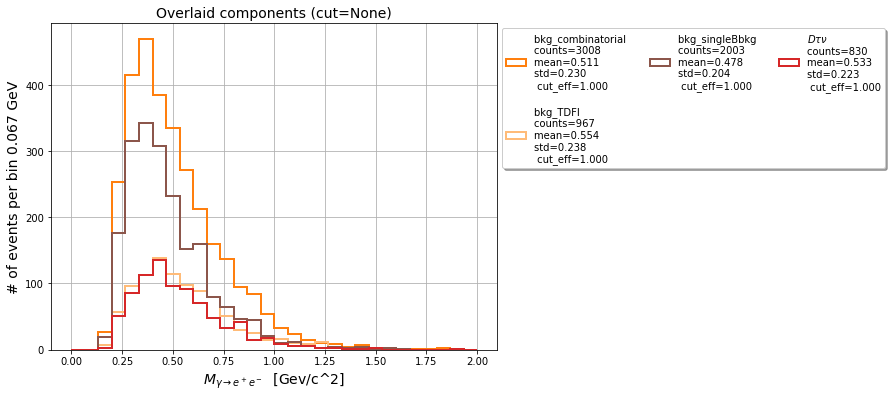

In [47]:
b1 = np.linspace(0,2,31)
mpl.plot_mc_1d_overlaid(variable='ell_photonVeto_M',bins=b1,mask=[],
                        cut=None,
                        show_only=[r'$D\tau\nu$','bkg_combinatorial','bkg_singleBbkg','bkg_TDFl'],density=False)
plt.xlabel('$M_{\gamma\\rightarrow e^+ e^-}$  [Gev/c^2]')

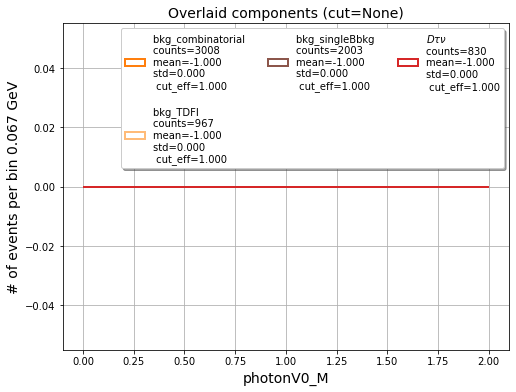

In [41]:
b1 = np.linspace(0,2,31)
mpl.plot_mc_1d_overlaid(variable='photonV0_M',bins=b1,mask=[],
                        cut=None,
                        show_only=[r'$D\tau\nu$','bkg_combinatorial','bkg_singleBbkg','bkg_TDFl'],density=False)

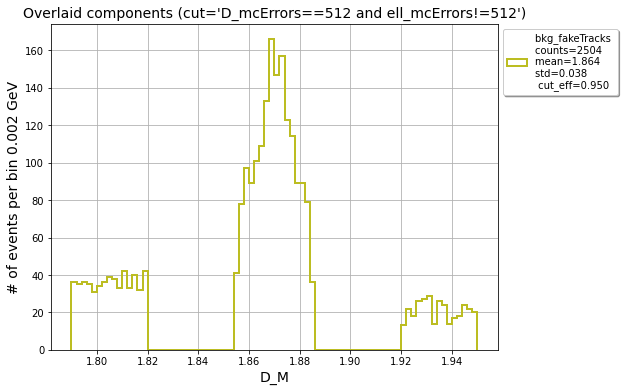

In [12]:
b1 = np.linspace(1.79,1.95,81)
mpl.plot_mc_1d_overlaid(variable='D_M',bins=b1,mask=[],
                        cut='D_mcErrors==512 and ell_mcErrors!=512',
                        show_only=['bkg_fakeTracks'],density=False)

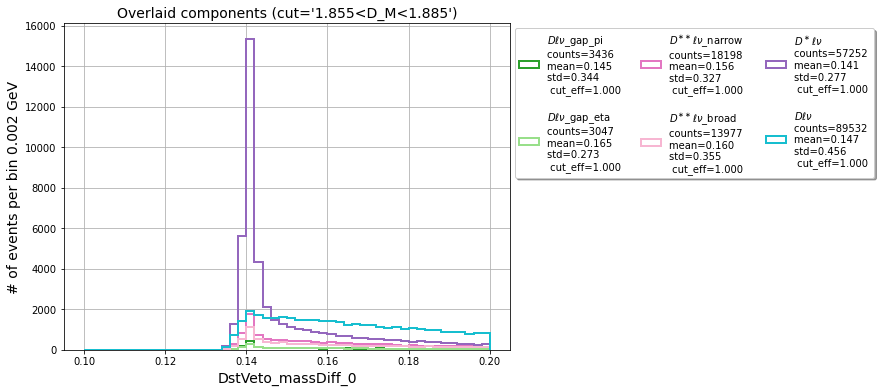

In [5]:
# pi0 eff50_1, photon tight cut
b1 = np.linspace(0.1,0.2,51)
mpl.plot_mc_1d_overlaid(variable='DstVeto_massDiff_0',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='norm',density=False)

In [7]:
# eff50_1 photon tight cut
veto_D = len(samples_generic[r'$D\ell\nu$'].query('0.135<DstVeto_massDiff_0<0.145'))
veto_Dst = len(samples_generic[r'$D^\ast\ell\nu$'].query('0.135<DstVeto_massDiff_0<0.145'))
print('veto D', veto_D, veto_D / 89532)
print('veto D*', veto_Dst, veto_Dst / 57252)

veto D 6711 0.07495644015547513
veto D* 27908 0.4874589533990079


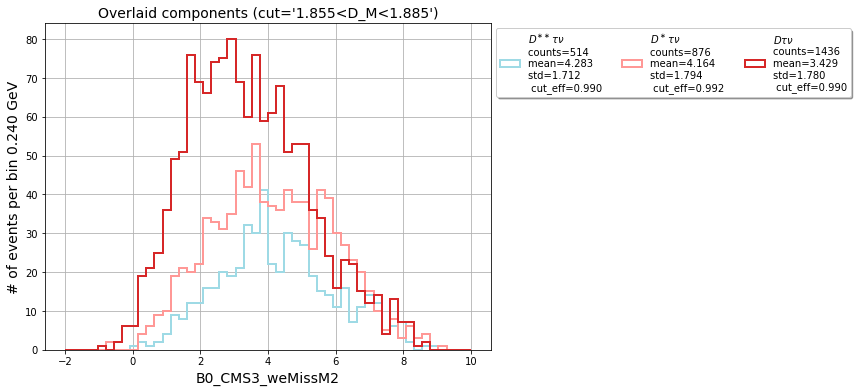

In [5]:
b1 = np.concatenate((np.linspace(-2.5,2.5,11), np.linspace(2.8,10,31) ) )
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',show_only='sig',density=False,
                        weights={r'$D\tau\nu$': 1,
                                 r'$D^\ast\tau\nu$': 1,
                                 r'$D^{\ast\ast}\tau\nu$': 1})

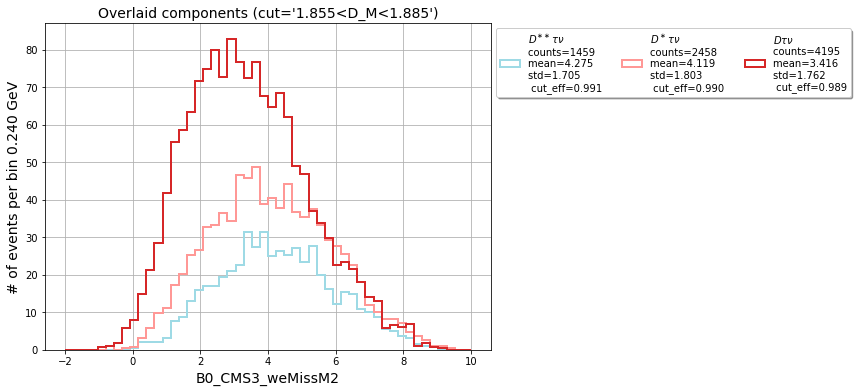

In [11]:
b1 = np.concatenate((np.linspace(-2.5,2.5,11), np.linspace(2.8,10,31) ) )
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',show_only='sig',density=False,
                        weights={r'$D\tau\nu$': 0.36,
                                 r'$D^\ast\tau\nu$': 0.36,
                                 r'$D^{\ast\ast}\tau\nu$': 0.36})

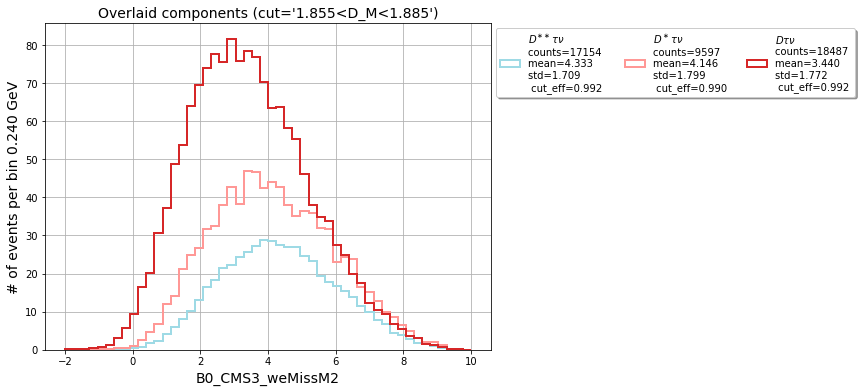

In [14]:
b1 = np.concatenate((np.linspace(-2.5,2.5,11), np.linspace(2.8,10,31) ) )
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',show_only='sig',density=False,
                        weights={r'$D\tau\nu$': 0.36 * 4195/18487, 
                                 r'$D^\ast\tau\nu$': 0.36 * 2458/9597, 
                                 r'$D^{\ast\ast}\tau\nu$': 0.36 * 1459/17154,})

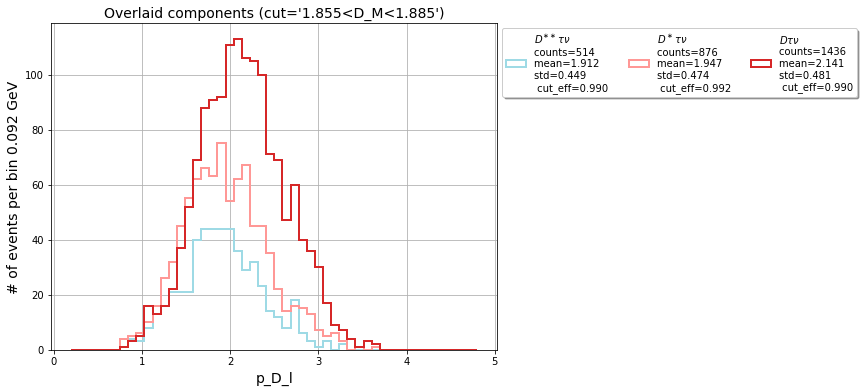

In [6]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',show_only='sig',density=False,
                        weights={r'$D\tau\nu$': 1, 
                                 r'$D^\ast\tau\nu$': 1, 
                                 r'$D^{\ast\ast}\tau\nu$': 1,})

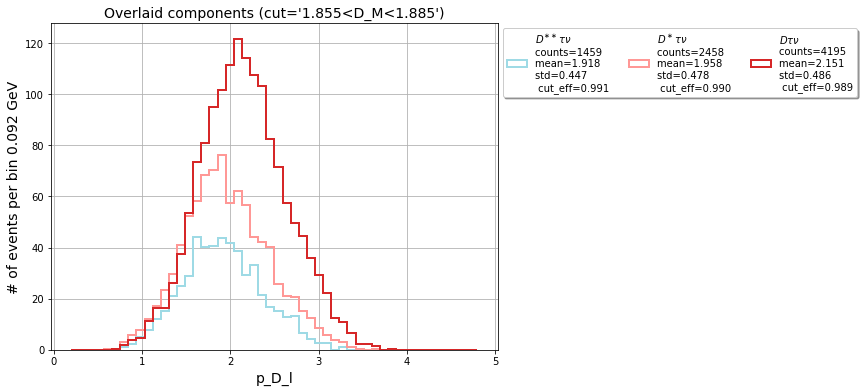

In [8]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',show_only='sig',density=False,
                        weights={r'$D\tau\nu$': 0.36, 
                                 r'$D^\ast\tau\nu$': 0.36, 
                                 r'$D^{\ast\ast}\tau\nu$': 0.36,})

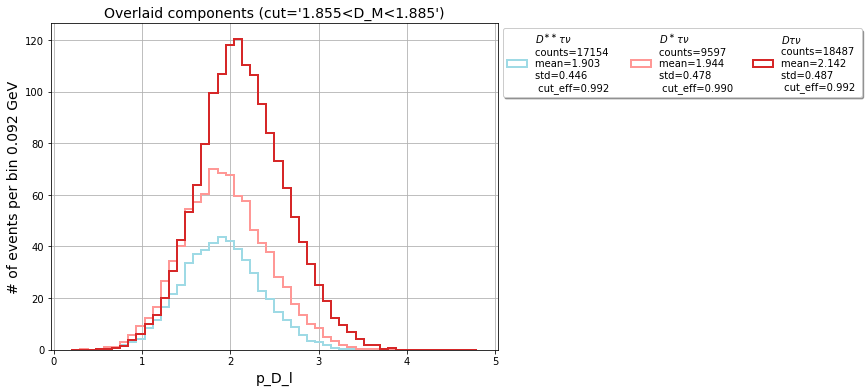

In [6]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',show_only='sig',density=False,
                        weights={r'$D\tau\nu$': 0.36 * 4195/18487, 
                                 r'$D^\ast\tau\nu$': 0.36 * 2458/9597, 
                                 r'$D^{\ast\ast}\tau\nu$': 0.36 * 1459/17154,})

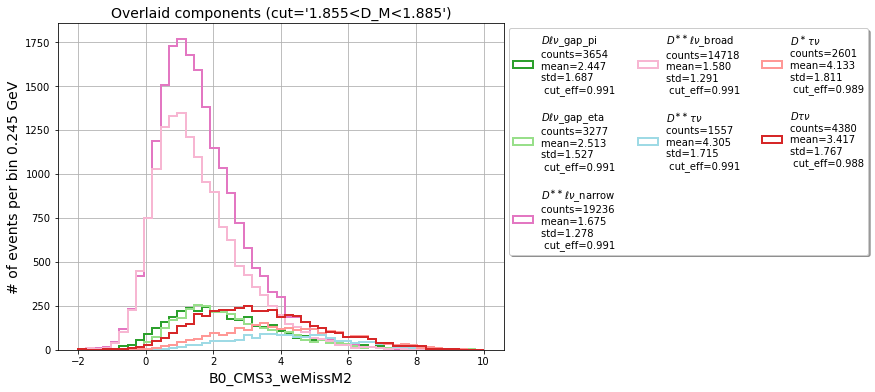

In [6]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

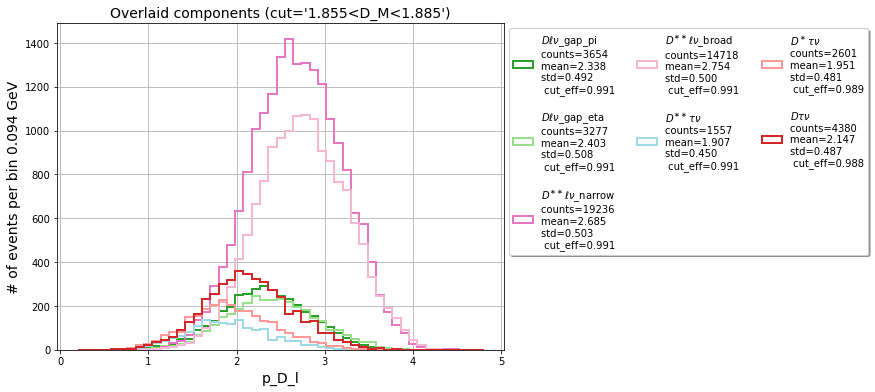

In [8]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

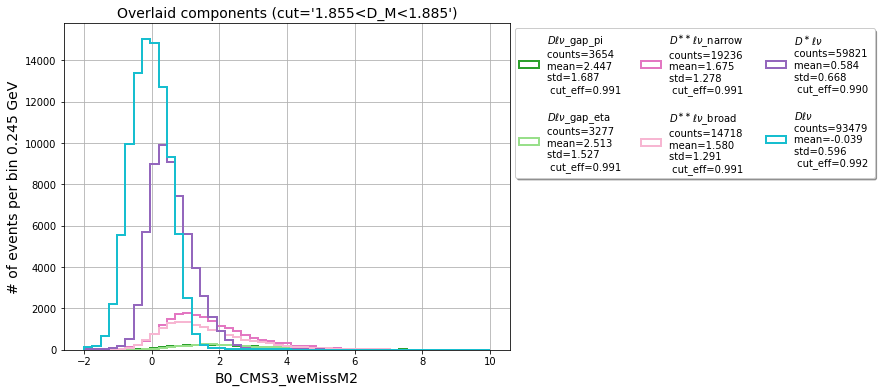

In [7]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,
                        cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

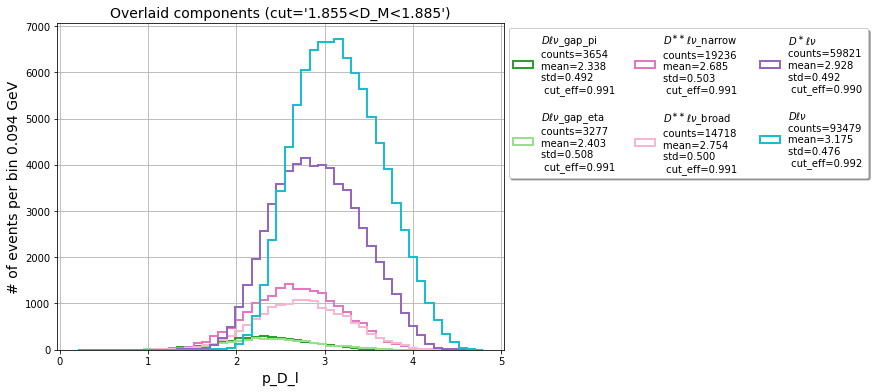

In [9]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

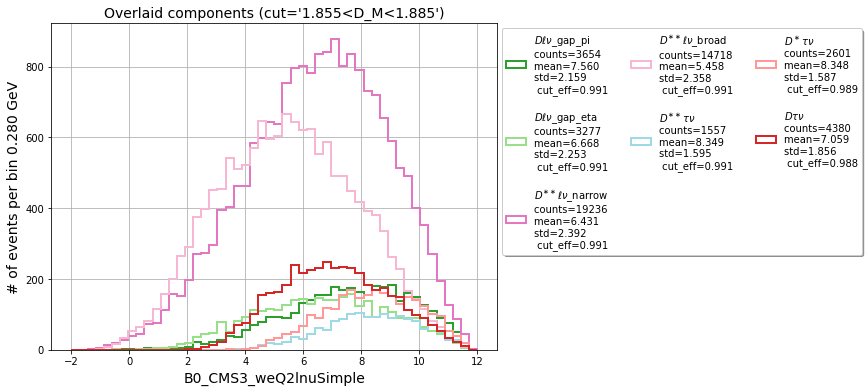

In [11]:
b1 = np.linspace(-2,12,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weQ2lnuSimple',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

# BKG composition

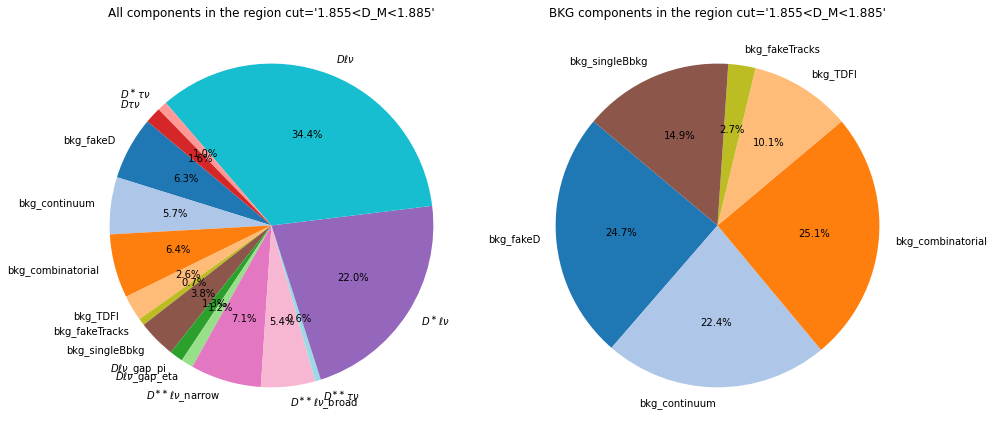

In [20]:
mpl.plot_pie()

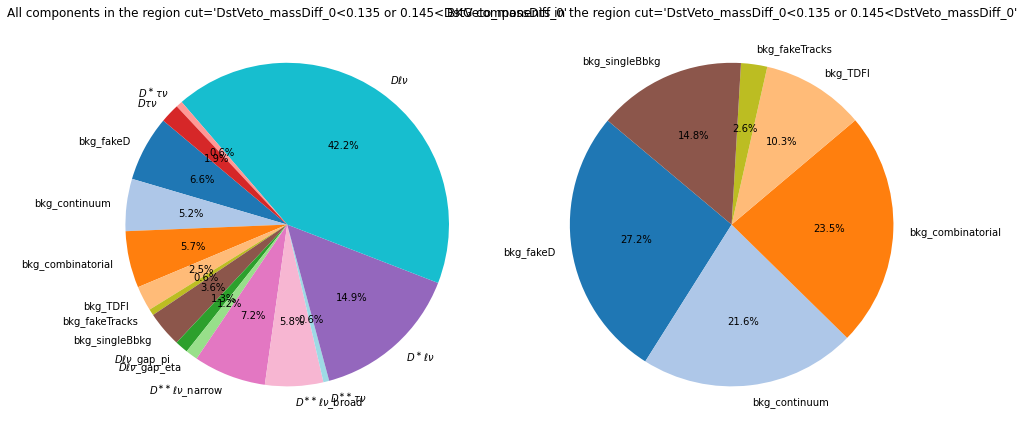

In [5]:
mpl.plot_pie(cut='DstVeto_massDiff_0<0.135 or 0.145<DstVeto_massDiff_0')

# Signal MC

In [14]:
# 4S Data vs MC

cut = '(5<B0_roeMbc_my_mask) & (-4<B0_roeDeltae_my_mask) & (B0_roeDeltae_my_mask<1)'

# Load data files
MC_sig = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_sig_quaxo_e_1/*.root:B0'],
                          library="np",
                          cut = cut,
                          filter_branch=lambda branch: branch.name in columns)

df_mc_sig = pd.DataFrame(MC_sig)

In [15]:
lgb_tight = 'sig_prob==largest_prob and sig_prob>0.6 and fakeD_prob<0.05'
ag_tight = 'sig_prob==largest_prob and sig_prob>0.8 and fakeD_prob<0.05'
MVA_all = 'D_M>0'

df_mc_sig.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
df_mc_sig.eval('p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

df_mc_sig_lgb = util.apply_mva_bcs(df_mc_sig, training_variables, lgb_tight, library='lgbm')

In [16]:
samples=util.get_dataframe_samples_new(df_mc_sig_lgb, 'e', template=False)
mpl=util.mpl(samples)
for name, df in samples.items():
    print(name, len(df))

bkg_fakeD 21978
bkg_TDFl 1998
bkg_fakeTracks 1456
bkg_continuum 0
bkg_combinatorial 13430
bkg_singleBbkg 2793
bkg_other_TDTl 0
$D\tau\nu$ 19505
$D^\ast\tau\nu$ 10179
$D\ell\nu$ 32183
$D^\ast\ell\nu$ 20601
$D^{\ast\ast}\tau\nu$ 18450
$D^{\ast\ast}\ell\nu$_narrow 6048
$D^{\ast\ast}\ell\nu$_broad 4185
$D\ell\nu$_gap_pi 1281
$D\ell\nu$_gap_eta 1458
bkg_other_signal 0


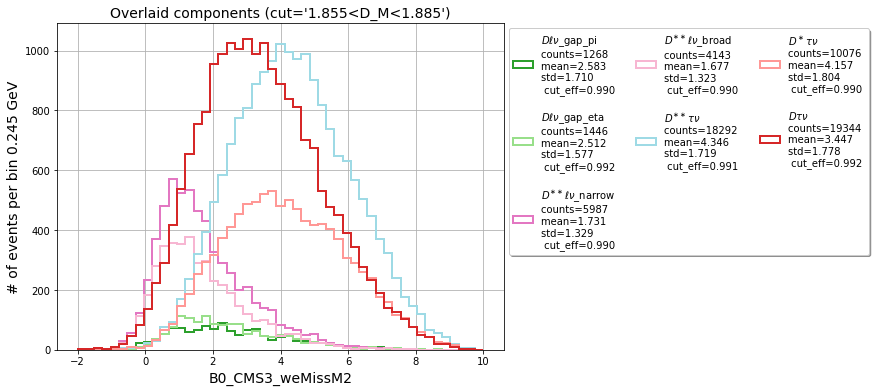

In [17]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

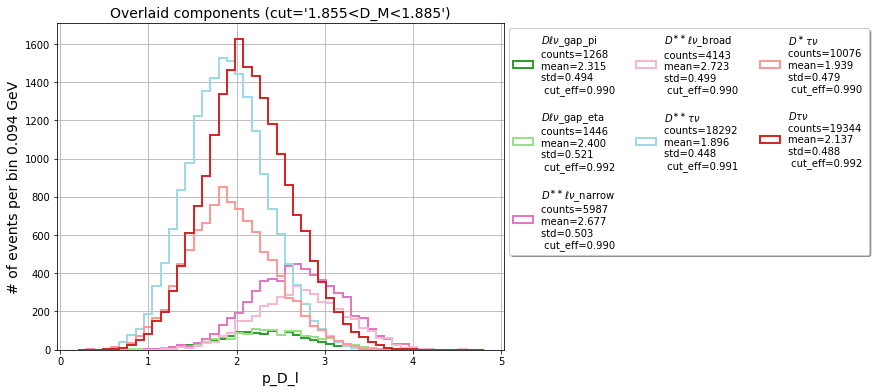

In [25]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,mask=[],
                        cut='1.855<D_M<1.885',
                        show_only='sig',density=False)

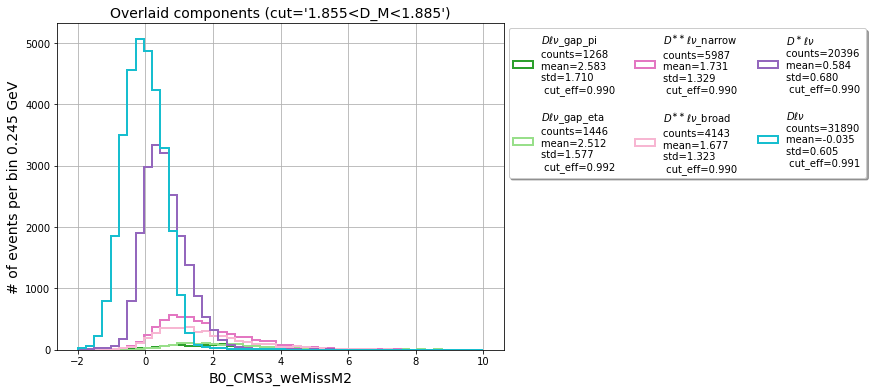

In [20]:
b1 = np.linspace(-2,10,51)
mpl.plot_mc_1d_overlaid(variable='B0_CMS3_weMissM2',bins=b1,
                        cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

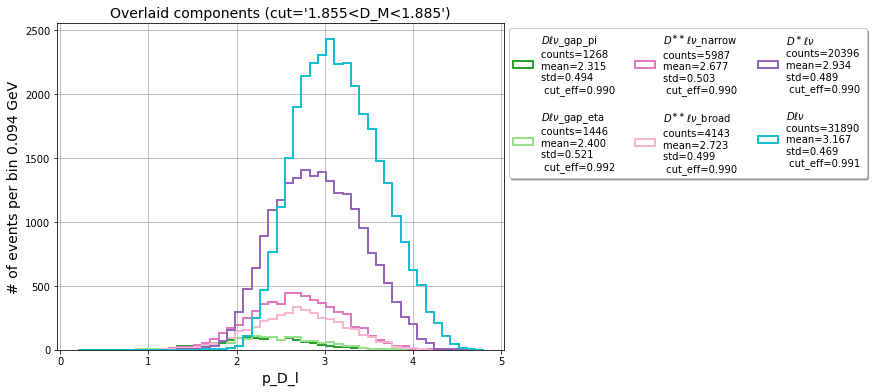

In [24]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,cut='1.855<D_M<1.885',mask=[],
                        show_only='norm',density=False)

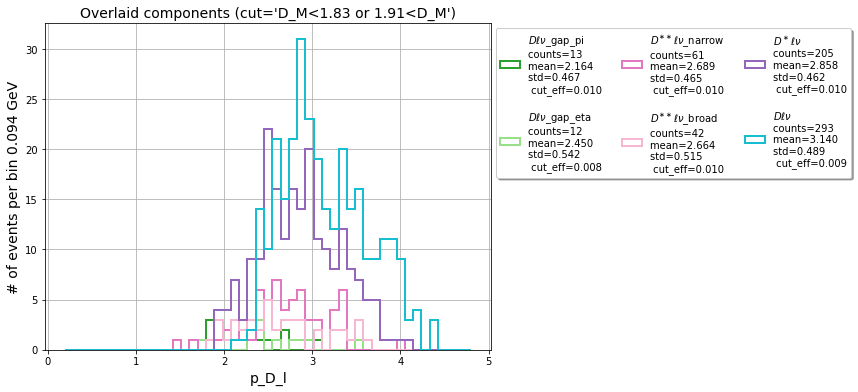

In [26]:
b1 = np.linspace(0.2,4.8,51)
mpl.plot_mc_1d_overlaid(variable='p_D_l',bins=b1,cut='D_M<1.83 or 1.91<D_M',mask=[],
                        show_only='norm',density=False)